In [1]:
!pip install -q transformers evaluate torch torchvision scikit-learn pandas pillow matplotlib tqdm kagglehub rouge_score nltk
# Try CheXbert metric (PyPI wrapper). If this fails in your env, we’ll fallback automatically later.
!pip install -q f1chexbert




[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os, kagglehub

# Download (first run takes time)
base = kagglehub.dataset_download("simhadrisadaram/mimic-cxr-dataset")
print("Dataset base:", base)

# Try to guess image root
candidates = [
    os.path.join(base, "official_data_iccv_final", "files"),
    os.path.join(base, "files"),
    base,
]
IMG_ROOT = next((p for p in candidates if os.path.isdir(p)), None)
if IMG_ROOT is None:
    for r, d, _ in os.walk(base):
        if any(x.startswith("p") for x in d):
            IMG_ROOT = r
            break
assert IMG_ROOT and os.path.isdir(IMG_ROOT), f"Images root not found under {base}"
print("IMG_ROOT:", IMG_ROOT)

def find_csv(root, name):
    for r, _, files in os.walk(root):
        if name in files:
            return os.path.join(r, name)
    return None

TRAIN_CSV = find_csv(base, "mimic_cxr_aug_train.csv")
VAL_CSV   = find_csv(base, "mimic_cxr_aug_validate.csv")
assert TRAIN_CSV and VAL_CSV, "Could not find train/val CSVs."
print("TRAIN_CSV:", TRAIN_CSV)
print("VAL_CSV:  ", VAL_CSV)


Resuming download from 186646528 bytes (17535689683 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/simhadrisadaram/mimic-cxr-dataset?dataset_version_number=2 (186646528/17722336211) bytes left.


100%|██████████| 16.5G/16.5G [08:39<00:00, 33.8MB/s] 

Extracting files...


Dataset base: /home/jovyan/.cache/kagglehub/datasets/simhadrisadaram/mimic-cxr-dataset/versions/2
IMG_ROOT: /home/jovyan/.cache/kagglehub/datasets/simhadrisadaram/mimic-cxr-dataset/versions/2/official_data_iccv_final/files
TRAIN_CSV: /home/jovyan/.cache/kagglehub/datasets/simhadrisadaram/mimic-cxr-dataset/versions/2/mimic_cxr_aug_train.csv
VAL_CSV:   /home/jovyan/.cache/kagglehub/datasets/simhadrisadaram/mimic-cxr-dataset/versions/2/mimic_cxr_aug_validate.csv


In [3]:
import re, math, random, warnings
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import AutoModel, AutoModelForSeq2SeqLM, AutoTokenizer, get_cosine_schedule_with_warmup
import evaluate

warnings.filterwarnings("ignore")

# Repro & device
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Backbones
VLP_MODEL_NAME     = "microsoft/rad-dino"           # ViT trunk pretrained on CXRs
DECODER_MODEL_NAME = "GanjinZero/biobart-v2-base"   # biomedical BART

# Train hparams (3 epochs fixed)
BATCH_SIZE   = 4
EPOCHS       = 3
GRAD_ACCUM   = 1
LR_VIT       = 3e-5
LR_HEAD      = 3e-4
WEIGHT_DECAY = 1e-2
WARMUP_RATIO = 0.05
CLIP_NORM    = 1.0

# Prompting / context
TARGET_SECTION         = "impression"  # could be "findings"
USE_FINDINGS_AS_PROMPT = True
INPUT_MAX_TOKENS       = 128           # encoder side
MAX_NEW_TOKENS         = 128           # decoder side

# IO
SAVE_DIR  = "./mimic_trained"
PLOTS_DIR = "./plots"
CKPT_DIR  = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)


Device: cuda


In [4]:
# === Cell 3 — Read CSVs & robust two-view pairing with wide auto-detection ===
import os, re
import pandas as pd

def read_csv_safely(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    return df

train_df = read_csv_safely(TRAIN_CSV)
val_df   = read_csv_safely(VAL_CSV)
print("Train rows:", len(train_df), "| Val rows:", len(val_df))
print("Columns:", list(train_df.columns))

# --- Try to Auto-detect key columns -----------------------------------------
# 1) Path-like columns: allow many variants (path, file, filename, jpg_path, etc.)
CAND_PATH_KEYS = (
    "path", "filepath", "img_path", "image_path", "jpg_path", "png_path",
    "file", "filename", "relative_path", "dicom_path"
)

def looks_like_path(v: str) -> bool:
    if not isinstance(v, str):
        return False
    v_low = v.lower()
    return ((".jpg" in v_low) or (".png" in v_low) or (".jpeg" in v_low) or ("/" in v_low) or ("\\" in v_low))

def pick_best_path_col(df: pd.DataFrame):
    # First try by column name keywords
    for k in CAND_PATH_KEYS:
        if k in df.columns:
            return k
    # Fallback: pick the object column that "looks most like a path"
    obj_cols = [c for c in df.columns if df[c].dtype == object]
    best_col, best_score = None, -1
    for c in obj_cols:
        sample = df[c].dropna().astype(str).head(500)
        score = sum(looks_like_path(x) for x in sample)
        if score > best_score:
            best_col, best_score = c, score
    return best_col

# 2) Separate frontal/lateral columns (if present) by name
def find_fr_lat_columns(df: pd.DataFrame):
    fr = None; lt = None
    for c in df.columns:
        lc = c.lower()
        if ("frontal" in lc or "pa" in lc or "ap" in lc) and ("path" in lc or "file" in lc or "name" in lc):
            fr = c
        if ("lateral" in lc or "lat" in lc) and ("path" in lc or "file" in lc or "name" in lc):
            lt = c
    return fr, lt

# 3) View & study columns (for grouping rows into studies)
VIEW_COL = next((c for c in ("view","viewposition","view_pos","projection") if c in train_df.columns), None)
STUDY_COL= next((c for c in ("study","study_id","studyid","study_instance_uid","study_uid") if c in train_df.columns), None)

# 4) Findings/Impression columns (targets/prompts)
FIND_COL = next((c for c in ("findings","finding","section_findings") if c in train_df.columns), None)
IMPR_COL = next((c for c in ("impression","impressions","section_impression") if c in train_df.columns), None)

print("Detected so far →",
      {"STUDY_COL":STUDY_COL, "VIEW_COL":VIEW_COL, "FIND_COL":FIND_COL, "IMPR_COL":IMPR_COL})

def build_abs_path(rel_or_abs: str) -> str:
    if not isinstance(rel_or_abs, str): rel_or_abs = str(rel_or_abs)
    rel_or_abs = rel_or_abs.strip()
    if os.path.isabs(rel_or_abs):
        return rel_or_abs
    return os.path.join(IMG_ROOT, rel_or_abs.lstrip("./"))

def sanity_check_paths(series: pd.Series, k_sample=200) -> float:
    """Return fraction of sampled rows that exist on disk after joining IMG_ROOT (or abs)."""
    s = series.dropna().astype(str).head(k_sample)
    if s.empty: return 0.0
    ok = 0
    for v in s:
        p = build_abs_path(v)
        if os.path.exists(p): ok += 1
    return ok / len(s)

def pair_views(df: pd.DataFrame) -> pd.DataFrame:
    # A) If explicit frontal/lateral path columns exist
    fr_col, lt_col = find_fr_lat_columns(df)
    if fr_col:
        print(f"[pair_views] Using explicit columns → frontal={fr_col}, lateral={lt_col or '(missing: will duplicate frontal)'}")
        fr_ok = sanity_check_paths(df[fr_col])
        lt_ok = sanity_check_paths(df[lt_col]) if lt_col else fr_ok
        print(f"  Path existence check: frontal={fr_ok:.2%}, lateral={lt_ok:.2%}")
        return pd.DataFrame({
            "frontal_path": df[fr_col].apply(build_abs_path),
            "lateral_path": df[lt_col].apply(build_abs_path) if lt_col else df[fr_col].apply(build_abs_path),
            "findings": df[FIND_COL] if FIND_COL else "",
            "impression": df[IMPR_COL] if IMPR_COL else "",
        })

    # B) Single path column + view (+ study) → group per study and pick PA/AP as frontal, LATERAL as lateral
    if VIEW_COL and STUDY_COL:
        pcol = pick_best_path_col(df)
        if pcol is None:
            raise ValueError("Could not find a path-like column with VIEW/STUDY present.")
        print(f"[pair_views] Grouping by study with pcol={pcol}, study={STUDY_COL}, view={VIEW_COL}")
        print(f"  Path existence (sample): {sanity_check_paths(df[pcol]):.2%}")

        tmp_cols = [STUDY_COL, pcol, VIEW_COL]
        if FIND_COL: tmp_cols.append(FIND_COL)
        if IMPR_COL: tmp_cols.append(IMPR_COL)
        tmp = df[tmp_cols].copy()
        tmp["__is_frontal"] = tmp[VIEW_COL].astype(str).str.upper().isin(["PA","AP"])
        tmp["__is_lateral"] = tmp[VIEW_COL].astype(str).str.upper().str.contains("LATERAL")

        rows = []
        for sid, g in tmp.groupby(STUDY_COL):
            fr = g.loc[g["__is_frontal"], pcol].tolist()
            lt = g.loc[g["__is_lateral"], pcol].tolist()
            if not fr:
                # If the study has no PA/AP, try best available as "frontal"
                any_paths = g[pcol].dropna().astype(str).tolist()
                if not any_paths:
                    continue
                fr_p = build_abs_path(any_paths[0])
                lt_p = fr_p
            else:
                fr_p = build_abs_path(fr[0])
                lt_p = build_abs_path(lt[0]) if lt else fr_p

            findings   = str(g[FIND_COL].iloc[0]) if FIND_COL and len(g[FIND_COL].dropna()) else ""
            impression = str(g[IMPR_COL].iloc[0]) if IMPR_COL and len(g[IMPR_COL].dropna()) else ""
            rows.append((fr_p, lt_p, findings, impression))

        return pd.DataFrame(rows, columns=["frontal_path","lateral_path","findings","impression"])

    # C) As a last resort: single path-like column, duplicate as lateral
    pcol = pick_best_path_col(df)
    if pcol:
        print(f"[pair_views] Fallback to single path column → {pcol}")
        print(f"  Path existence (sample): {sanity_check_paths(df[pcol]):.2%}")
        return pd.DataFrame({
            "frontal_path": df[pcol].apply(build_abs_path),
            "lateral_path": df[pcol].apply(build_abs_path),
            "findings": df[FIND_COL] if FIND_COL else "",
            "impression": df[IMPR_COL] if IMPR_COL else "",
        })

    # D) If we get here, we truly cannot infer
    print("DEBUG: Object columns head values:")
    for c in [c for c in df.columns if df[c].dtype == object]:
        print(f" - {c}: {df[c].astype(str).head(3).tolist()}")
    raise ValueError("Could not infer image path columns from CSV. "
                     "Please tell me which column(s) hold image paths and (optionally) view/study info.")

# --- Build pairs
train_pairs = pair_views(train_df)
val_pairs   = pair_views(val_df)
print("Paired → train:", len(train_pairs), "| val:", len(val_pairs))

# Effective ratio AFTER pairing (what the model will actually see)
n_train, n_val = len(train_pairs), len(val_pairs)
print(f"Train:Val = {n_train}:{n_val}  (~{n_train/max(1,n_val):.2f}:1)")
print(f"Train % ≈ {100*n_train/(n_train+n_val):.1f}%,  Val % ≈ {100*n_val/(n_train+n_val):.1f}%")
train_pairs.head()


Train rows: 64586 | Val rows: 500
Columns: ['unnamed: 0.1', 'unnamed: 0', 'subject_id', 'image', 'view', 'ap', 'pa', 'lateral', 'text', 'text_augment']
Detected so far → {'STUDY_COL': None, 'VIEW_COL': 'view', 'FIND_COL': None, 'IMPR_COL': None}
[pair_views] Fallback to single path column → image
  Path existence (sample): 0.00%
[pair_views] Fallback to single path column → image
  Path existence (sample): 0.00%
Paired → train: 64586 | val: 500
Train:Val = 64586:500  (~129.17:1)
Train % ≈ 99.2%,  Val % ≈ 0.8%


,frontal_path,lateral_path,findings,impression
0,/home/jovyan/.cache/kagglehub/datasets/simhadr...,/home/jovyan/.cache/kagglehub/datasets/simhadr...,,
1,/home/jovyan/.cache/kagglehub/datasets/simhadr...,/home/jovyan/.cache/kagglehub/datasets/simhadr...,,
2,/home/jovyan/.cache/kagglehub/datasets/simhadr...,/home/jovyan/.cache/kagglehub/datasets/simhadr...,,
3,/home/jovyan/.cache/kagglehub/datasets/simhadr...,/home/jovyan/.cache/kagglehub/datasets/simhadr...,,
4,/home/jovyan/.cache/kagglehub/datasets/simhadr...,/home/jovyan/.cache/kagglehub/datasets/simhadr...,,


In [5]:
# === Robust & fast dataset/dataloaders with aggressive path normalization/debug ===
import os, ast, re, pickle, time
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# -------- toggles --------
SUBSAMPLE   = 0   # e.g., 2000 for quick tests; 0 = all
NUM_WORKERS = 4
IMG_EXTS    = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}

train_tf = T.Compose([
    T.Resize((224,224)),
    T.RandomApply([T.RandomRotation(3)], p=0.3),
    T.RandomApply([T.ColorJitter(brightness=0.10, contrast=0.10)], p=0.3),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5),
])
val_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5),
])

# -------- filename index (basename -> full path) cached to disk --------
INDEX_CACHE = os.path.join(IMG_ROOT, ".file_index.pkl")

def build_file_index(root: str, exts=IMG_EXTS, cache_path=INDEX_CACHE):
    t0 = time.time()
    if os.path.isfile(cache_path):
        with open(cache_path, "rb") as f:
            idx = pickle.load(f)
        print(f"[index] loaded cached index with {len(idx)} basenames from {cache_path} in {time.time()-t0:.1f}s")
        return idx
    idx = {}
    for r, _, files in os.walk(root):
        for fn in files:
            if os.path.splitext(fn)[1].lower() in {e.lower() for e in exts}:
                idx.setdefault(fn, []).append(os.path.join(r, fn))
    with open(cache_path, "wb") as f:
        pickle.dump(idx, f)
    print(f"[index] built index with {len(idx)} basenames in {time.time()-t0:.1f}s (cached to {cache_path})")
    return idx

FILE_INDEX = build_file_index(IMG_ROOT)

# -------- helpers: parse & normalize weird CSV path blobs --------
IMG_RE = re.compile(r"(?:^|['\"\[\],\s])(files\/[A-Za-z0-9_\-\/\.]+?\.(?:jpg|jpeg|png))", re.IGNORECASE)

def _extract_first_path_from_blob(val):
    """
    Return a single candidate path string from a value that may be:
    - a list/tuple,
    - a stringified Python list,
    - a raw string containing multiple 'files/...jpg' segments.
    """
    if isinstance(val, (list, tuple)):
        return str(val[0]) if val else ""
    s = str(val).strip()
    # Try literal list parse first
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
            if isinstance(lst, (list, tuple)) and len(lst):
                return str(lst[0])
        except Exception:
            pass
    # Regex fallback: grab first files/...jpg-like token
    m = IMG_RE.search(s)
    if m:
        return m.group(1)
    return s  # last resort

def _fix_double_files(p):
    # collapse any ".../files/files/..." to ".../files/..."
    return p.replace("/files/files/", "/files/").replace("\\files\\files\\", "\\files\\")

def _canon_path(p):
    """
    Normalize relative -> absolute under IMG_ROOT.
    Handle when CSV already starts with 'files/' and IMG_ROOT ends with '/files'.
    """
    p = str(p).strip().strip("'\"")
    if not p: return ""
    p = _fix_double_files(p)
    if os.path.isabs(p):
        return p

    # If CSV path starts with 'files/' but IMG_ROOT already ends with '.../files',
    # join with the parent of IMG_ROOT to avoid doubling 'files'.
    if p.lower().startswith("files/") and os.path.basename(IMG_ROOT.rstrip("/\\")).lower() == "files":
        base_root = os.path.dirname(IMG_ROOT.rstrip("/\\"))
        return _fix_double_files(os.path.join(base_root, p))

    # Otherwise join under IMG_ROOT
    return _fix_double_files(os.path.join(IMG_ROOT, p.lstrip("./")))

def _resolve_with_index(p):
    """
    Return an existing path; if not present, resolve by basename via FILE_INDEX.
    """
    if p and os.path.exists(p):
        return p
    if not p:
        return ""
    base = os.path.basename(p)
    hits = FILE_INDEX.get(base, [])
    return hits[0] if hits else ""

# -------- dataset --------
class MIMICPairDataset(Dataset):
    def __init__(self, df_pairs: pd.DataFrame, transform, subsample=0):
        self.transform = transform

        df_use = df_pairs.sample(n=min(subsample, len(df_pairs)), random_state=42) if subsample else df_pairs

        rows = []
        dropped = 0
        debug_samples = []

        for _, row in df_use.iterrows():
            fp_raw = _extract_first_path_from_blob(row.get("frontal_path", ""))
            lp_raw = _extract_first_path_from_blob(row.get("lateral_path", ""))

            fp_try = _canon_path(fp_raw)
            lp_try = _canon_path(lp_raw)

            fp = _resolve_with_index(fp_try)
            lp = _resolve_with_index(lp_try)

            if fp and lp and os.path.exists(fp) and os.path.exists(lp):
                rows.append({
                    "frontal_path": fp,
                    "lateral_path": lp,
                    "findings": str(row.get("findings", "") or ""),
                    "impression": str(row.get("impression", "") or ""),
                })
            else:
                dropped += 1
                if len(debug_samples) < 5:
                    debug_samples.append({
                        "frontal_raw": str(fp_raw)[:200],
                        "lateral_raw": str(lp_raw)[:200],
                        "frontal_canon": fp_try,
                        "lateral_canon": lp_try,
                        "frontal_resolved_exist": os.path.exists(fp),
                        "lateral_resolved_exist": os.path.exists(lp),
                        "frontal_resolved": fp,
                        "lateral_resolved": lp,
                    })

        self.df = pd.DataFrame(rows).reset_index(drop=True)
        kept = len(self.df)
        print(f"[MIMICPairDataset] kept {kept} pairs, dropped {dropped} (missing/invalid paths).")

        if kept == 0:
            print("⚠️ Debug samples of failed resolutions:")
            for i, s in enumerate(debug_samples, 1):
                print(f"--- Fail {i} ---")
                for k,v in s.items():
                    print(f"{k}: {v}")
            raise RuntimeError(
                "No valid image pairs left after path resolution. "
                "Check IMG_ROOT and how paths are stored in CSV (see debug above)."
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        f = Image.open(row["frontal_path"]).convert("RGB")
        l = Image.open(row["lateral_path"]).convert("RGB")
        return (
            self.transform(f),
            self.transform(l),
            row["findings"],
            row["impression"],
        )

def collate_fn(batch):
    f_imgs, l_imgs, finds, imps = [], [], [], []
    for a,b,c,d in batch:
        f_imgs.append(a); l_imgs.append(b); finds.append(c); imps.append(d)
    return torch.stack(f_imgs), torch.stack(l_imgs), finds, imps

# -------- build loaders --------
train_ds = MIMICPairDataset(train_pairs, train_tf, subsample=SUBSAMPLE)
val_ds   = MIMICPairDataset(val_pairs,   val_tf,   subsample=0)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)

# Quick sanity check
f0, l0, _, _ = train_ds[0]
print("Sample tensors:", f0.shape, l0.shape, "| batches:", len(train_loader), len(val_loader))


[index] built index with 261137 basenames in 6.3s (cached to /home/jovyan/.cache/kagglehub/datasets/simhadrisadaram/mimic-cxr-dataset/versions/2/official_data_iccv_final/files/.file_index.pkl)
[MIMICPairDataset] kept 45224 pairs, dropped 19362 (missing/invalid paths).
[MIMICPairDataset] kept 338 pairs, dropped 162 (missing/invalid paths).
Sample tensors: torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) | batches: 11306 85


In [6]:
class TwoViewVisionReportModel(nn.Module):
    def __init__(self, vit, decoder, tokenizer, proj_dim, num_prefix_tokens=1):
        super().__init__()
        self.vit, self.decoder, self.tokenizer = vit, decoder, tokenizer
        self.proj = nn.Linear(vit.config.hidden_size, proj_dim)
        self.num_prefix_tokens = num_prefix_tokens

    def _build_encoder_inputs(self, img_f, img_l, prompts_list):
        device = img_f.device
        out_f = self.vit(pixel_values=img_f).last_hidden_state[:,0]
        out_l = self.vit(pixel_values=img_l).last_hidden_state[:,0]
        avg   = 0.5*(out_f + out_l)
        prefix= self.proj(avg).unsqueeze(1)                       # [B,1,D]
        if self.num_prefix_tokens > 1:
            prefix = prefix.repeat(1, self.num_prefix_tokens, 1)  # [B,P,D]

        enc = self.tokenizer(prompts_list, return_tensors="pt", padding=True,
                             truncation=True, max_length=INPUT_MAX_TOKENS).to(device)
        txt_emb = self.decoder.get_encoder().embed_tokens(enc.input_ids)
        inputs_embeds  = torch.cat([prefix, txt_emb], dim=1)
        prefix_mask    = torch.ones(inputs_embeds.size(0), prefix.size(1), device=device, dtype=torch.long)
        attention_mask = torch.cat([prefix_mask, enc.attention_mask], dim=1)
        return inputs_embeds, attention_mask

    def forward(self, img_f, img_l, prompts_list, impressions=None):
        inputs_embeds, attention_mask = self._build_encoder_inputs(img_f, img_l, prompts_list)
        labels = None
        if impressions is not None:
            dec = self.tokenizer(impressions, return_tensors="pt", padding=True,
                                 truncation=True, max_length=INPUT_MAX_TOKENS).to(inputs_embeds.device)
            labels = dec.input_ids
        return self.decoder(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels)

    @torch.inference_mode()
    def generate(self, img_f, img_l, prompts_list, **gen_kwargs):
        inputs_embeds, attention_mask = self._build_encoder_inputs(img_f, img_l, prompts_list)
        defaults = dict(max_new_tokens=MAX_NEW_TOKENS, num_beams=4, no_repeat_ngram_size=2,
                        length_penalty=1.0, repetition_penalty=1.12, early_stopping=True,
                        eos_token_id=self.tokenizer.eos_token_id)
        defaults.update(gen_kwargs or {})
        return self.decoder.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, **defaults)

# Load backbones
vit       = AutoModel.from_pretrained(VLP_MODEL_NAME).to(device)
decoder   = AutoModelForSeq2SeqLM.from_pretrained(DECODER_MODEL_NAME).to(device)
tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL_NAME)

model = TwoViewVisionReportModel(vit, decoder, tokenizer, proj_dim=decoder.config.d_model, num_prefix_tokens=1).to(device)


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/666M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [7]:
# === Cell A (fixed): Build pairs from MIMIC-AUG (image/ap/pa/lateral/text), then reload loaders ===
import os, re, ast, glob, pickle
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ----------------------------
# 0) File index (basename -> full paths) to resolve relative/missing paths
# ----------------------------
INDEX_CACHE = os.path.join(IMG_ROOT, ".file_index.pkl")
if os.path.isfile(INDEX_CACHE):
    with open(INDEX_CACHE, "rb") as f:
        FILE_INDEX = pickle.load(f)
else:
    FILE_INDEX = {}
    for ext in ("*.jpg","*.jpeg","*.png"):
        for fp in glob.glob(os.path.join(IMG_ROOT, "**", ext), recursive=True):
            FILE_INDEX.setdefault(os.path.basename(fp), []).append(fp)
    with open(INDEX_CACHE, "wb") as f:
        pickle.dump(FILE_INDEX, f)
    print(f"[index] built with {sum(len(v) for v in FILE_INDEX.values())} entries")

# ----------------------------
# 1) Helpers for path + view parsing
# ----------------------------
def _parse_list(x):
    """Return list from list/tuple/stringified-list; else [] if empty."""
    if isinstance(x, (list, tuple)):
        return list(x)
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple)):
                return list(val)
        except Exception:
            return []
    return [s] if s else []

def _canon_path(p: str) -> str:
    """Absolute path under IMG_ROOT; fix duplicated /files/ segments."""
    p = str(p).strip().strip("'\"")
    if not p:
        return ""
    p = p.replace("/files/files/", "/files/")
    if os.path.isabs(p):
        return p
    # If path starts with files/ and IMG_ROOT ends in 'files', join with its parent
    if p.lower().startswith("files/") and os.path.basename(IMG_ROOT.rstrip("/\\")).lower() == "files":
        base_root = os.path.dirname(IMG_ROOT.rstrip("/\\"))
        return os.path.join(base_root, p)
    return os.path.join(IMG_ROOT, p.lstrip("./"))

def _resolve(p: str) -> str:
    """Return an existing full path; otherwise fallback to basename lookup."""
    if p and os.path.exists(p):
        return p
    if not p:
        return ""
    base = os.path.basename(p)
    hits = FILE_INDEX.get(base, [])
    return hits[0] if hits else ""

def _select_frontal(row):
    """Prefer PA, then AP; else align image+view; else first image."""
    pa = _parse_list(row.get("pa", []))
    ap = _parse_list(row.get("ap", []))
    if pa:
        return pa[0]
    if ap:
        return ap[0]
    imgs  = _parse_list(row.get("image", []))
    views = [str(v).upper() for v in _parse_list(row.get("view", []))]
    if len(imgs) == len(views) and len(imgs) > 0:
        for im, vw in zip(imgs, views):
            if vw in ("PA", "AP"):
                return im
        return imgs[0]
    return imgs[0] if imgs else ""

def _select_lateral(row, fallback_frontal):
    """Pick explicit lateral; else align image+view for 'LATERAL'; else fallback to frontal."""
    lat = _parse_list(row.get("lateral", []))
    if lat:
        return lat[0]
    imgs  = _parse_list(row.get("image", []))
    views = [str(v).upper() for v in _parse_list(row.get("view", []))]
    if len(imgs) == len(views) and len(imgs) > 0:
        for im, vw in zip(imgs, views):
            if "LATERAL" in vw:
                return im
    return fallback_frontal

# ----------------------------
# 2) Extract Findings / Impression from 'text' (or 'text_augment' fallback)
# ----------------------------
def _extract_sections(raw_text: str):
    """
    Return (findings, impression) parsed from a combined note.
    Handles 'Findings:' and 'Impression:' markers; falls back gracefully.
    Also normalizes common placeholders like 'x-xxxx' -> 'x-ray'.
    """
    s = str(raw_text or "")
    s = re.sub(r"<br\s*/?>", "\n", s, flags=re.IGNORECASE)
    s = re.sub(r"x-?xxxx", "x-ray", s, flags=re.IGNORECASE)
    s = s.replace("\r", "")
    m_find = re.search(r"\bfindings\s*:\s*", s, flags=re.IGNORECASE)
    m_impr = re.search(r"\bimpression\s*:\s*", s, flags=re.IGNORECASE)
    findings, impression = "", ""
    if m_find and m_impr:
        findings   = s[m_find.end():m_impr.start()].strip()
        impression = s[m_impr.end():].strip()
    elif m_impr:
        impression = s[m_impr.end():].strip()
    elif m_find:
        findings = s[m_find.end():].strip()
    else:
        findings = s.strip()
    # light cleanup
    findings   = re.sub(r"\s+", " ", findings).strip()
    impression = re.sub(r"\s+", " ", impression).strip()
    return findings, impression

# ----------------------------
# 3) Build pair tables (frontal_path, lateral_path, findings, impression)
# ----------------------------
def build_pairs_from_df(df: pd.DataFrame) -> pd.DataFrame:
    rows, dropped = [], 0
    for _, r in df.iterrows():
        fr_rel = _select_frontal(r)
        la_rel = _select_lateral(r, fr_rel)
        fr = _resolve(_canon_path(fr_rel))
        la = _resolve(_canon_path(la_rel))
        if not fr:  # require frontal
            dropped += 1
            continue

        raw_text = r.get("text", "")
        if not str(raw_text).strip():
            raw_text = r.get("text_augment", "")

        findings, impression = _extract_sections(raw_text)
        rows.append({
            "frontal_path": fr,
            "lateral_path": la if la else fr,
            "findings": findings,
            "impression": impression
        })
    out = pd.DataFrame(rows)
    print(f"[pairs] kept {len(out)} rows, dropped {dropped} (missing frontal).")
    if len(out):
        print(f"[pairs] coverage → findings: {(out['findings'].str.strip()!='').mean():.1%}, "
              f"impression: {(out['impression'].str.strip()!='').mean():.1%}")
    return out

train_pairs = build_pairs_from_df(train_df)
val_pairs   = build_pairs_from_df(val_df)

# ----------------------------
# 4) Dataset & DataLoaders expected by your training loop (findings prompt, impression target)
# ----------------------------
train_tf = T.Compose([
    T.Resize((224,224)),
    T.RandomApply([T.RandomRotation(3)], p=0.3),
    T.RandomApply([T.ColorJitter(brightness=0.10, contrast=0.10)], p=0.3),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5),
])
val_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5),
])

class MIMICPairDataset(Dataset):
    def __init__(self, df_pairs: pd.DataFrame, transform):
        self.df = df_pairs.reset_index(drop=True)
        self.transform = transform
        if len(self.df) == 0:
            raise RuntimeError("No pairs available; check CSVs and IMG_ROOT.")
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        f = Image.open(row["frontal_path"]).convert("RGB")
        l = Image.open(row["lateral_path"]).convert("RGB")
        # training uses: (img_f, img_l, finds, imps)
        return (
            self.transform(f),
            self.transform(l),
            str(row.get("findings","") or ""),
            str(row.get("impression","") or "")
        )

def collate_fn(batch):
    f_imgs, l_imgs, finds, imps = [], [], [], []
    for a,b,c,d in batch:
        f_imgs.append(a); l_imgs.append(b); finds.append(c); imps.append(d if d.strip() else c)  # fallback: if no impression, use findings as target
    return torch.stack(f_imgs), torch.stack(l_imgs), finds, imps

BATCH_SIZE  = globals().get("BATCH_SIZE", 8)
NUM_WORKERS = globals().get("NUM_WORKERS", 4)

train_loader = DataLoader(
    MIMICPairDataset(train_pairs, train_tf),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    MIMICPairDataset(val_pairs,   val_tf),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn
)

# Quick sanity
f0,l0,find0,imp0 = next(iter(val_loader))
print("Sanity:", f0.shape, l0.shape, "| example findings len:", len(find0[0]), "| example impression len:", len(imp0[0]))


[pairs] kept 45224 rows, dropped 19362 (missing frontal).
[pairs] coverage → findings: 78.2%, impression: 100.0%
[pairs] kept 338 rows, dropped 162 (missing frontal).
[pairs] coverage → findings: 77.5%, impression: 100.0%
Sanity: torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 224, 224]) | example findings len: 0 | example impression len: 3789


In [9]:
# === Cell: Clean training + placeholder removal + safe 2-beam decoding + packaged saving ===
import os, re, json, math, time, torch
from tqdm import tqdm
from contextlib import nullcontext
from transformers import get_cosine_schedule_with_warmup

# ---------- sanity ----------
for need in ("model","tokenizer","train_loader","val_loader","device"):
    if need not in globals():
        raise RuntimeError(f"Missing required object: '{need}'.")

torch.backends.cudnn.benchmark = True

# ---------- defaults (can be overridden above) ----------
CKPT_DIR       = globals().get("CKPT_DIR", "./checkpoints")
SAVE_DIR       = globals().get("SAVE_DIR", "./mimic_trained")
EPOCHS         = globals().get("EPOCHS", 3)
GRAD_ACCUM     = globals().get("GRAD_ACCUM", 1)
CLIP_NORM      = globals().get("CLIP_NORM", 1.0)
LR_VIT         = globals().get("LR_VIT", 3e-5)
LR_HEAD        = globals().get("LR_HEAD", 3e-4)
WEIGHT_DECAY   = globals().get("WEIGHT_DECAY", 0.01)
WARMUP_RATIO   = globals().get("WARMUP_RATIO", 0.06)
USE_AMP        = False  # keep fp32 for stability against NaNs

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------- tokenizer / decoder safety ----------
# Guarantee a pad token
if getattr(tokenizer, "pad_token_id", None) is None:
    if getattr(tokenizer, "eos_token_id", None) is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        try:
            model.decoder.resize_token_embeddings(len(tokenizer))
        except Exception:
            pass
if getattr(model.decoder.config, "pad_token_id", None) is None:
    model.decoder.config.pad_token_id = tokenizer.pad_token_id
try:
    model.decoder.generation_config.pad_token_id = tokenizer.pad_token_id
except Exception:
    pass

PAD_ID = tokenizer.pad_token_id
EOS_ID = tokenizer.eos_token_id or tokenizer.pad_token_id

# ---------- text cleaning / normalization ----------
PHI_BRACKET = re.compile(r"\[\*\*.*?\*\*\]")           # remove de-identified spans
MULTI_UND   = re.compile(r"_{2,}")                     # ___ → (remove)
BROKEN_ASC  = re.compile(r"[\uFFFD]+")                 # � chars
MULTI_SPACE = re.compile(r"\s{2,}")
DUP_WORDS   = re.compile(r"\b(\w{2,10})(?:\s+\1){1,}\b", re.IGNORECASE)  # the the → the
REPEAT_SYL  = re.compile(r"\b([a-z]{2,4})\1{2,}\b", re.IGNORECASE)       # effeffeff → eff

def _clean_unicode(t: str) -> str:
    t = str(t)
    t = BROKEN_ASC.sub(" ", t)
    t = t.replace("\x00", " ")
    return t

def normalize_text(t: str) -> str:
    t = _clean_unicode(t)
    t = t.replace("<BR>", " ").replace("<br>", " ")
    t = re.sub(r"x-+x+", "x-ray", t, flags=re.IGNORECASE)
    t = MULTI_SPACE.sub(" ", t).strip()
    return t

def sanitize_label_text(t: str) -> str:
    """
    Clean training targets so the model doesn't learn placeholders like ___ or [**...**].
    """
    t = _clean_unicode(t)
    t = PHI_BRACKET.sub(" ", t)
    t = MULTI_UND.sub(" ", t)        # remove ___
    t = t.replace("`", "'")
    t = normalize_text(t)
    # collapse crazy repetitions early
    t = DUP_WORDS.sub(r"\1", t)
    t = REPEAT_SYL.sub(r"\1", t)
    # ensure reasonable ending
    if t and t[-1].isalpha():
        t += "."
    return t

def clean_pred_text(t: str) -> str:
    """
    Post-process decoder output to remove odd fragments (unfinished words, repeats, underscores).
    """
    t = normalize_text(t)
    t = PHI_BRACKET.sub(" ", t)
    t = MULTI_UND.sub(" ", t)
    t = re.sub(r"\s*[\[\]\(\)\{\}]\s*", " ", t)  # drop stray brackets
    t = DUP_WORDS.sub(r"\1", t)
    t = REPEAT_SYL.sub(r"\1", t)
    # trim repeated punctuation & whitespace
    t = re.sub(r"([,;:\.\-])\1{1,}", r"\1", t)
    t = MULTI_SPACE.sub(" ", t).strip()
    # lightly enforce sentence end
    if t and t[-1] not in ".!?":
        t += "."
    return t

# ---------- clinical labels & metrics ----------
_LABELS = {
    "pleural effusion": [r"\bpleural\s+effusion(s)?\b", r"\beffusion(s)?\b"],
    "pneumothorax":     [r"\bpneumothorax\b", r"\bptx\b"],
    "edema":            [r"\bpulmonary\s+edema\b", r"\bedema\b"],
    "consolidation":    [r"\bconsolidation(s)?\b", r"\bair\s*space\s*opacity\b", r"\balveolar\s+opacity\b"],
    "atelectasis":      [r"\batelectasis\b", r"\bplate\s*atelectasis\b"],
    "cardiomegaly":     [r"\bcardiomegaly\b", r"\benlarged\s+cardiac\s+silhouette\b", r"\benlarged\s+heart\b"],
    "pneumonia":        [r"\bpneumonia\b"],
    "nodule":           [r"\bnodule(s)?\b", r"\bnodular\b"],
    "mass":             [r"\bmass(es)?\b"],
    "fracture":         [r"\bfracture(s)?\b"],
    "emphysema":        [r"\bemphysema(tous)?\b"],
}
def extract_labels(text: str):
    text = normalize_text(text).lower()
    out = set()
    for canon, pats in _LABELS.items():
        for p in pats:
            if re.search(p, text):
                out.add(canon); break
    return out

def compute_clinical_f1(pred_texts, ref_texts):
    eps = 1e-9; tp=fp=fn=0
    for p,r in zip(pred_texts, ref_texts):
        P, R = extract_labels(p), extract_labels(r)
        tp += len(P & R); fp += len(P - R); fn += len(R - P)
    prec = tp / (tp + fp + eps); rec = tp / (tp + fn + eps)
    return 2*prec*rec/(prec + rec + eps)

# ---------- overlap metrics (safe) ----------
import evaluate as hf_evaluate
_bleu   = hf_evaluate.load("bleu")
_rouge  = hf_evaluate.load("rouge")
_meteor = hf_evaluate.load("meteor")
def safe_overlap_metrics(preds, refs):
    preds = [normalize_text(p) for p in preds]
    refs  = [normalize_text(r) for r in refs]
    if not preds or not refs or all(not r for r in refs):
        return 0.0, 0.0, 0.0, 0.0
    try:   bleu   = _bleu.compute(predictions=preds, references=[[r] for r in refs])["bleu"]
    except Exception: bleu = 0.0
    try:   rougeL = _rouge.compute(predictions=preds, references=refs)["rougeL"]
    except Exception: rougeL = 0.0
    try:   meteor = _meteor.compute(predictions=preds, references=refs)["meteor"]
    except Exception: meteor = 0.0
    return bleu, rougeL, meteor, (bleu+rougeL+meteor)/3.0

# ---------- prompts ----------
def build_prompts(findings_batch):
    out = []
    for f in findings_batch:
        f = sanitize_label_text(f)  # sanitize also the prompt content
        if f:
            out.append("FINDINGS: " + f + " Write a concise IMPRESSION in complete sentences without placeholders.")
        else:
            out.append("Write a concise IMPRESSION in complete sentences without placeholders.")
    return out

# ---------- build 'bad_words_ids' to ban underscores & stray brackets ----------
def build_bad_ids(tok):
    bad_strings = [
        "___", "__", "_",  # underscores
        "[", "]", " [", " ]",  # raw brackets
        "<br>", "<BR>", "xxxx", "XXXX", " x ", "xx", "�"
    ]
    bad_ids = []
    for s in bad_strings:
        ids = tok.encode(s, add_special_tokens=False)
        if ids:
            bad_ids.append(ids)
    # also ban repeated underscore tokens like "_ _"
    u = tok.encode("_", add_special_tokens=False)
    if u: bad_ids.append(u+u)
    # drop duplicates
    uniq = []
    seen = set()
    for seq in bad_ids:
        key = tuple(seq)
        if key not in seen:
            uniq.append(seq); seen.add(key)
    return uniq

BAD_WORDS_IDS = build_bad_ids(tokenizer)

# ---------- safe generation config (2-beam, no sampling) ----------
GEN_BEAMS = dict(
    do_sample=False,
    num_beams=2,
    no_repeat_ngram_size=4,
    repetition_penalty=1.08,
    length_penalty=1.05,
    min_new_tokens=48,
    max_new_tokens=128,
    remove_invalid_values=True,
    bad_words_ids=BAD_WORDS_IDS or None,
    pad_token_id=PAD_ID,
    eos_token_id=EOS_ID,
)

def safe_generate(img_f1, img_l1, prompt1, gen_kwargs=GEN_BEAMS):
    try:
        ids = model.generate(img_f1, img_l1, [prompt1], **gen_kwargs)
        return clean_pred_text(tokenizer.decode(ids[0], skip_special_tokens=True))
    except Exception:
        # fallback greedy
        ids = model.generate(
            img_f1, img_l1, [prompt1],
            do_sample=False, num_beams=1,
            max_new_tokens=96, remove_invalid_values=True,
            bad_words_ids=BAD_WORDS_IDS or None,
            no_repeat_ngram_size=4, repetition_penalty=1.08,
            pad_token_id=PAD_ID, eos_token_id=EOS_ID
        )
        return clean_pred_text(tokenizer.decode(ids[0], skip_special_tokens=True))

# ---------- optim & scheduler ----------
def build_optim_scheduler(m, total_steps, lr_vit, lr_head, warmup_ratio=WARMUP_RATIO):
    opt = torch.optim.AdamW(
        [{"params": m.vit.parameters(), "lr": lr_vit},
         {"params": list(m.proj.parameters()) + list(m.decoder.parameters()), "lr": lr_head}],
        weight_decay=WEIGHT_DECAY
    )
    warm = max(1, int(total_steps*warmup_ratio))
    sch = get_cosine_schedule_with_warmup(opt, warm, total_steps)
    return opt, sch

def freeze_all_vit(m):
    for p in m.vit.parameters(): p.requires_grad = False

def unfreeze_last_vit_block(m):
    for p in m.vit.parameters(): p.requires_grad = False
    names = [n for n,_ in m.vit.named_parameters()]
    pats  = [r"encoder\.layer\.(\d+)\.", r"blocks\.(\d+)\.", r"layer\.(\d+)\."]
    import re as _re
    last_idx=None; last_pat=None
    for pat in pats:
        idxs=[]
        for n in names:
            mobj=_re.search(pat, n)
            if mobj:
                try: idxs.append(int(mobj.group(1)))
                except: pass
        if idxs:
            mx=max(idxs)
            if last_idx is None or mx>last_idx:
                last_idx, last_pat = mx, pat
    if last_idx is None:
        for p in m.vit.parameters(): p.requires_grad = True
        return
    block_re = _re.compile(last_pat.replace("(\\d+)", str(last_idx)))
    for n,p in m.vit.named_parameters():
        if block_re.search(n): p.requires_grad = True

# ---------- training ----------
def train_clean(model, train_loader, val_loader,
                lr_vit=LR_VIT, lr_head=LR_HEAD,
                epochs=EPOCHS, grad_accum=GRAD_ACCUM):
    scaler = torch.amp.GradScaler('cuda', enabled=False)  # fp32 path
    def autocast(): return nullcontext()

    total_steps = epochs * math.ceil(len(train_loader)/max(1,grad_accum))
    optim, sched = build_optim_scheduler(model, total_steps, lr_vit, lr_head)

    hist = {"train_loss":[], "val_loss":[], "bleu":[], "rougeL":[], "meteor":[], "avg3":[], "clin_f1":[]}
    best_clin, best_dir = -1.0, None

    freeze_all_vit(model)
    PLACEHOLDER = "No acute cardiopulmonary abnormality."

    for epoch in range(1, epochs+1):
        if epoch == 2: unfreeze_last_vit_block(model)

        # ---- train
        model.train()
        t_loss = 0.0
        optim.zero_grad(set_to_none=True)
        for step, (img_f, img_l, finds, imps) in enumerate(tqdm(train_loader, desc=f"Train {epoch}")):
            img_f, img_l = img_f.to(device), img_l.to(device)
            labels = [sanitize_label_text(x) if str(x).strip() else PLACEHOLDER for x in imps]
            prompts = build_prompts(finds)

            with autocast():
                out = model(img_f, img_l, prompts, impressions=labels)
                loss = out.loss / grad_accum

            if not torch.isfinite(loss):
                optim.zero_grad(set_to_none=True)
                continue

            loss.backward()
            if (step+1) % grad_accum == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                optim.step(); sched.step()
                optim.zero_grad(set_to_none=True)

            t_loss += float(out.loss.detach()) * img_f.size(0)
        t_loss /= max(1, len(train_loader.dataset))

        # ---- validate (2-beam, banned underscores)
        model.eval()
        v_loss = 0.0
        preds, refs = [], []
        with torch.no_grad():
            for img_f, img_l, finds, imps in tqdm(val_loader, desc=f"Val {epoch}"):
                img_f, img_l = img_f.to(device), img_l.to(device)
                labels  = [sanitize_label_text(x) if str(x).strip() else PLACEHOLDER for x in imps]
                prompts = build_prompts(finds)

                with autocast():
                    out = model(img_f, img_l, prompts, impressions=labels)
                if torch.isfinite(out.loss):
                    v_loss += float(out.loss) * img_f.size(0)

                for b in range(img_f.size(0)):
                    pred = safe_generate(img_f[b:b+1], img_l[b:b+1], prompts[b], GEN_BEAMS)
                    preds.append(pred); refs.append(labels[b])

        v_loss /= max(1, len(val_loader.dataset))

        bleu, rougeL, meteor, avg3 = safe_overlap_metrics(preds, refs)
        clin_f1 = compute_clinical_f1(preds, refs)

        hist["train_loss"].append(t_loss); hist["val_loss"].append(v_loss)
        hist["bleu"].append(bleu); hist["rougeL"].append(rougeL); hist["meteor"].append(meteor); hist["avg3"].append(avg3)
        hist["clin_f1"].append(clin_f1)

        print(f"\n📘 Epoch {epoch} — Train: {t_loss:.4f} | Val: {v_loss:.4f}")
        print(f"BLEU={bleu:.4f} | ROUGE-L={rougeL:.4f} | METEOR={meteor:.4f} | ClinF1={clin_f1:.4f} | Avg3={avg3:.4f}\n")
        if preds:
            print("🔍 Sample Predictions:")
            for i in range(min(2, len(preds))):
                print(f"Ref:  {refs[i][:220]}")
                print(f"Pred: {preds[i][:220]}\n")

        if clin_f1 > best_clin:
            best_clin = clin_f1
            best_dir  = os.path.join(CKPT_DIR, f"best_by_clinf1_e{epoch}")
            os.makedirs(best_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(best_dir, "model.pt"))
            print(f"💾 Saved best-by-ClinF1 (ClinF1={clin_f1:.4f}) → {best_dir}")

    return hist, best_dir

history, best_ckpt = train_clean(model, train_loader, val_loader,
                                 lr_vit=LR_VIT, lr_head=LR_HEAD,
                                 epochs=EPOCHS, grad_accum=GRAD_ACCUM)
print("Best-by-ClinF1 ckpt:", best_ckpt)

# ---------- packaged saving ----------
def _packaged_save(model, tokenizer, root_dir: str):
    os.makedirs(root_dir, exist_ok=True)
    vit_dir = os.path.join(root_dir, "vit"); os.makedirs(vit_dir, exist_ok=True)
    try: model.vit.save_pretrained(vit_dir)
    except Exception: torch.save(model.vit.state_dict(), os.path.join(vit_dir, "pytorch_model.bin"))
    dec_dir = os.path.join(root_dir, "decoder"); os.makedirs(dec_dir, exist_ok=True)
    try: model.decoder.save_pretrained(dec_dir)
    except Exception: torch.save(model.decoder.state_dict(), os.path.join(dec_dir, "pytorch_model.bin"))
    tokenizer.save_pretrained(dec_dir)
    torch.save(model.proj.state_dict(), os.path.join(root_dir, "proj.bin"))
    with open(os.path.join(root_dir, "hparams.json"), "w") as f:
        json.dump({
            "epochs": EPOCHS, "lr_vit": LR_VIT, "lr_head": LR_HEAD,
            "weight_decay": WEIGHT_DECAY, "warmup_ratio": WARMUP_RATIO,
            "decode": {"beams": GEN_BEAMS},
            "saved_at_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())
        }, f, indent=2)

final_dir = os.path.join(SAVE_DIR, "final")
_packaged_save(model, tokenizer, final_dir)
print("✅ Saved FINAL packaged model →", final_dir)

if best_ckpt and os.path.isdir(best_ckpt):
    sd = torch.load(os.path.join(best_ckpt, "model.pt"), map_location="cpu")
    model.load_state_dict(sd, strict=True)
    best_dir = os.path.join(SAVE_DIR, "best_clinf1")
    _packaged_save(model, tokenizer, best_dir)
    print("✅ Saved BEST-by-ClinF1 packaged model →", best_dir)
else:
    print("ℹ️ No best-by-ClinF1 checkpoint found; skipping BEST package.")


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Val 1: 100%|██████████| 85/85 [02:46<00:00,  1.96s/it]



📘 Epoch 1 — Train: 0.7560 | Val: 0.7663
BLEU=0.0418 | ROUGE-L=0.1400 | METEOR=0.2171 | ClinF1=0.4911 | Avg3=0.1330

🔍 Sample Predictions:
Ref:  Compared to chest radiographs since , most recently . Large right and moderate left pleural effusions and severe bibasilar atelectasis are unchanged. Cardiac silhouette is obscured. No pneumothorax. Pulmonary edema is mi
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Findings: PA and lateral views of the chest were provi

Ref:  ', 'Findings: Low lung volumes, no pleural effusions. No parenchymal abnormality, in particular no evidence of pneumonia. Borderline size of the cardiac silhouette without pulmonary edema. No hilar or mediastinal abnorma
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Finding

Val 2: 100%|██████████| 85/85 [02:45<00:00,  1.94s/it]



📘 Epoch 2 — Train: 0.6854 | Val: 0.7077
BLEU=0.0463 | ROUGE-L=0.1374 | METEOR=0.2068 | ClinF1=0.4685 | Avg3=0.1301

🔍 Sample Predictions:
Ref:  Compared to chest radiographs since , most recently . Large right and moderate left pleural effusions and severe bibasilar atelectasis are unchanged. Cardiac silhouette is obscured. No pneumothorax. Pulmonary edema is mi
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Findings: The lungs are clear without focal consolidat

Ref:  ', 'Findings: Low lung volumes, no pleural effusions. No parenchymal abnormality, in particular no evidence of pneumonia. Borderline size of the cardiac silhouette without pulmonary edema. No hilar or mediastinal abnorma
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Finding

Val 3: 100%|██████████| 85/85 [02:44<00:00,  1.94s/it]



📘 Epoch 3 — Train: 0.5863 | Val: 0.6984
BLEU=0.0395 | ROUGE-L=0.1347 | METEOR=0.1970 | ClinF1=0.4911 | Avg3=0.1237

🔍 Sample Predictions:
Ref:  Compared to chest radiographs since , most recently . Large right and moderate left pleural effusions and severe bibasilar atelectasis are unchanged. Cardiac silhouette is obscured. No pneumothorax. Pulmonary edema is mi
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Findings: The lungs are clear without focal consolidat

Ref:  ', 'Findings: Low lung volumes, no pleural effusions. No parenchymal abnormality, in particular no evidence of pneumonia. Borderline size of the cardiac silhouette without pulmonary edema. No hilar or mediastinal abnorma
Pred: In comparison with the study of , there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Finding

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


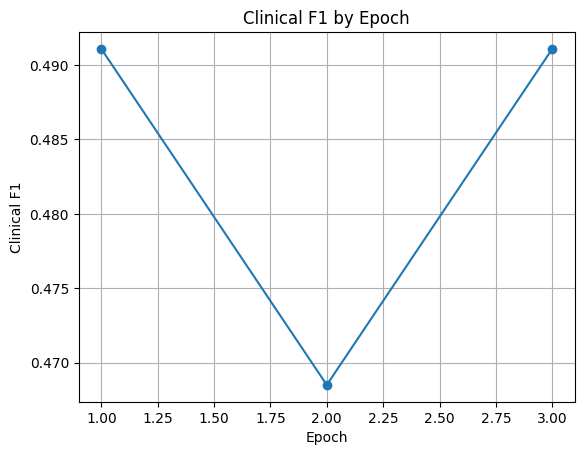

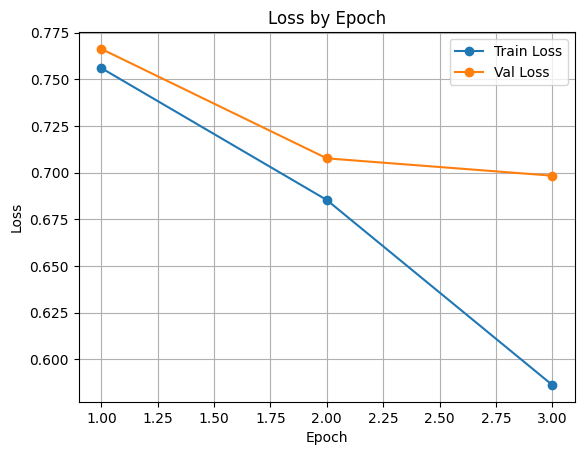

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [11]:
# Plot epochs vs Clinical F1, and Train vs Val loss from `history`
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Validate that `history` exists
if "history" not in globals() or not isinstance(history, dict):
    raise RuntimeError("`history` not found. Please run the training cell first to populate it.")

# Build a tidy DataFrame
hist_df = pd.DataFrame(history)
# Ensure epoch column
hist_df["epoch"] = range(1, len(hist_df) + 1)

# 1) Epochs vs Clinical F1
plt.figure()
plt.plot(hist_df["epoch"], hist_df["clin_f1"], marker="o")
plt.title("Clinical F1 by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Clinical F1")
plt.grid(True)
out1 = Path("plots/epoch_vs_clinf1.png")
plt.savefig(out1, dpi=160, bbox_inches="tight")
plt.show()

# 2) Train vs Val Loss
plt.figure()
plt.plot(hist_df["epoch"], hist_df["train_loss"], marker="o", label="Train Loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], marker="o", label="Val Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
out2 = Path("plots/train_vs_val_loss.png")
plt.savefig(out2, dpi=160, bbox_inches="tight")
plt.show()

# Show the table too (handy for quick checks)
from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("Training History", hist_df)

print(f"Saved: {out1}")
print(f"Saved: {out2}")


In [15]:
import shutil

# Define the folder you want to zip and the zip file output path
folder_to_zip = "plots"
zip_output_path = "plots.zip"

# Create the zip file
shutil.make_archive(base_name=zip_output_path.replace(".zip", ""), format='zip', root_dir=folder_to_zip)

print(f"✅ Folder zipped successfully: {zip_output_path}")


✅ Folder zipped successfully: plots.zip
